The purpose of this notebook is to use the gapfilled model for making growth predictions on single carbon sources. To do this, I will need to generate media conditions using the 192 carbon sources and the Biolog salts. Then, I need to run FBA and see if the model loaded is able to produce growth given the single carbon source. This will be a simple yes no to growth.

In [8]:
import cobra
import pandas as pd
import medusa
from pickle import load

In [9]:
#load up me ensebmle that i will be running carbon simulations on
with open("../results/ensembles/psy_ensemble_100_for_analysis.pickle", 'rb') as infile:
    ensemble = load(infile)

In [10]:
#define the base biolog media first
#first is the base composition, these are the salts that are necessary for growth, but alone do not contribute to growth
#/ minimally so
from medusa.test import load_biolog_plata
biolog_base_composition, biolog_base_dict, biolog_thresholded = load_biolog_plata()
biolog_base_composition = biolog_base_composition.drop(18)
biolog_base_composition = biolog_base_composition.drop(19)
biolog_base_composition

,Name,ID
0,H2O,cpd00001_e
1,O2,cpd00007_e
2,Phosphate,cpd00009_e
3,CO2,cpd00011_e
4,NH3,cpd00013_e
5,Mn2+,cpd00030_e
6,Zn2+,cpd00034_e
7,Sulfate,cpd00048_e
8,Cu2+,cpd00058_e
9,Ca2+,cpd00063_e


In [11]:
# convert the biolog base to a dictionary, which we can use to set ensemble.base_model.medium directly.
biolog_base = {'EX_'+component:1000 for component in biolog_base_composition['ID']}

#set heme to the lowest import value possible


# Double check that the objective is set to the biomass reaction.
# For this model, 'bio1' is the id of the biomass reaction.
ensemble.base_model.objective = 'bio1'

biolog_base

{'EX_cpd00001_e': 1000,
 'EX_cpd00007_e': 1000,
 'EX_cpd00009_e': 1000,
 'EX_cpd00011_e': 1000,
 'EX_cpd00013_e': 1000,
 'EX_cpd00030_e': 1000,
 'EX_cpd00034_e': 1000,
 'EX_cpd00048_e': 1000,
 'EX_cpd00058_e': 1000,
 'EX_cpd00063_e': 1000,
 'EX_cpd00067_e': 1000,
 'EX_cpd00099_e': 1000,
 'EX_cpd00149_e': 1000,
 'EX_cpd00205_e': 1000,
 'EX_cpd00254_e': 1000,
 'EX_cpd00971_e': 1000,
 'EX_cpd10515_e': 1000,
 'EX_cpd10516_e': 1000}

In [16]:
biolog_medias = pd.read_csv("../data/biologplates.csv")
for x in biolog_medias.ID:
    if 'cpd00322' in x:
        print ('yes')

yes


For each metabolite in biolog_medias dataframe, I will create a list of the single carbon source, as well as all of the metabolites present in biolog_salts dataframe. With each of these lists, I will open only those metabolites' exchange reactions, allowing flux of those metabolites into the model.  

In [17]:
from cobra import Reaction, Metabolite
ile = ensemble.base_model.metabolites.cpd00322_c.copy()
ile.compartment = "e"
ile.id = "cpd00322_e"
rxn = Reaction('EX_cpd00322_e')
rxn.add_metabolites({ile : -1000})
ensemble.base_model.add_reactions([rxn])

Ignoring reaction 'EX_cpd00322_e' since it already exists.


In [18]:
for reactions in ensemble.base_model.reactions:
    if 'EX_cpd00322' in reactions.id:
        print (reactions.id)

EX_cpd00322_e


In [19]:
carbon_sources_biolog = []
biolog_medias_list = {}    
for i in biolog_medias.itertuples(): 
    i = "EX_" + i.ID 
    if i in ensemble.base_model.reactions:
        carbon_sources_biolog.append(i)
    #biolog_medias_list[i.ID] = i.Name


In [23]:
df = pd.DataFrame.from_dict(biolog_medias_list, orient = 'index')
df.to_csv('../results/biolog_media_list.csv')

In [89]:
from medusa.flux_analysis import flux_balance

fluxes = {}
for carbon_source in carbon_sources_biolog:
    biolog_base[carbon_source] = 10
    ensemble.base_model.medium = biolog_base
    fluxes[carbon_source] = flux_balance.optimize_ensemble(ensemble,return_flux='bio1', num_processes = 4)
    biolog_base[carbon_source] = 0

In [17]:
with pd.ExcelWriter('../results/fluxes_SCS.xlsx') as writer:
    for key, value in fluxes.items():
        print (key)
        value.to_excel(writer, sheet_name= str(key))

EX_cpd00121_e
EX_cpd00281_e
EX_cpd00108_e
EX_cpd00053_e
EX_cpd00129_e
EX_cpd00314_e
EX_cpd00138_e
EX_cpd00027_e
EX_cpd00224_e
EX_cpd00076_e
EX_cpd01293_e
EX_cpd00023_e
EX_cpd00154_e
EX_cpd00035_e
EX_cpd00249_e
EX_cpd00222_e
EX_cpd00652_e
EX_cpd00386_e
EX_cpd00117_e
EX_cpd00246_e
EX_cpd00132_e
EX_cpd00054_e
EX_cpd00082_e
EX_cpd00105_e
EX_cpd00477_e
EX_cpd00164_e
EX_cpd00137_e
EX_cpd01307_e
EX_cpd00248_e
EX_cpd00130_e
EX_cpd00106_e
EX_cpd11585_e
EX_cpd00041_e
EX_cpd00119_e
EX_cpd00280_e
EX_cpd00020_e
EX_cpd00036_e
EX_cpd00100_e
EX_cpd02351_e
EX_cpd00051_e
EX_cpd00107_e
EX_cpd00432_e
EX_cpd00666_e


In [102]:
fluxes

{'EX_cpd00121_e':                       bio1
 PST_gapfilled_25  3.101595
 PST_gapfilled_26  2.801331
 PST_gapfilled_27  3.090915
 PST_gapfilled_28  3.087815
 PST_gapfilled_29  2.801817
 PST_gapfilled_30  3.089929
 PST_gapfilled_31  3.087815
 PST_gapfilled_32  3.100602
 PST_gapfilled_33  3.089929
 PST_gapfilled_34  3.100602
 PST_gapfilled_35  3.100602
 PST_gapfilled_36  3.089929
 PST_gapfilled_37  3.089929
 PST_gapfilled_38  3.089929
 PST_gapfilled_39  2.801817
 PST_gapfilled_40  3.099610
 PST_gapfilled_41  3.100602
 PST_gapfilled_42  3.101595
 PST_gapfilled_43  2.801331
 PST_gapfilled_44  2.801331
 PST_gapfilled_45  3.100602
 PST_gapfilled_46  2.796096
 PST_gapfilled_47  3.101595
 PST_gapfilled_48  2.819060
 PST_gapfilled_49  3.089929
 PST_gapfilled_0   2.800289
 PST_gapfilled_1   2.801331
 PST_gapfilled_2   2.801331
 PST_gapfilled_3   2.906534
 PST_gapfilled_4   3.090915
 ...                    ...
 PST_gapfilled_70  2.801331
 PST_gapfilled_71  3.100602
 PST_gapfilled_72  2.906534
 PS

In [14]:
carbon_sources_biolog = []
biolog_medias_list = []    
for i in biolog_medias.itertuples(): 
    i = "EX_" + i.ID 
    carbon_sources_biolog.append(i)

In [33]:
flux_df = pd.DataFrame.from_dict(fluxes, orient = 'index')
flux_df.to_csv("../results/biolog_fluxes.csv")

In [61]:
n = -1
for x in carbon_sources_biolog:
    n = n+1
    print (x, n)

EX_cpd00121_e 0
EX_cpd00281_e 1
EX_cpd00108_e 2
EX_cpd00053_e 3
EX_cpd00129_e 4
EX_cpd00314_e 5
EX_cpd00138_e 6
EX_cpd00027_e 7
EX_cpd00224_e 8
EX_cpd00076_e 9
EX_cpd01293_e 10
EX_cpd00023_e 11
EX_cpd00154_e 12
EX_cpd00035_e 13
EX_cpd00249_e 14
EX_cpd00222_e 15
EX_cpd00652_e 16
EX_cpd00386_e 17
EX_cpd00117_e 18
EX_cpd00246_e 19
EX_cpd00132_e 20
EX_cpd00054_e 21
EX_cpd00082_e 22
EX_cpd00105_e 23
EX_cpd00477_e 24
EX_cpd00164_e 25
EX_cpd00137_e 26
EX_cpd01307_e 27
EX_cpd00248_e 28
EX_cpd00130_e 29
EX_cpd00106_e 30
EX_cpd11585_e 31
EX_cpd00041_e 32
EX_cpd00119_e 33
EX_cpd00280_e 34
EX_cpd00020_e 35
EX_cpd00036_e 36
EX_cpd00100_e 37
EX_cpd02351_e 38
EX_cpd00051_e 39
EX_cpd00107_e 40
EX_cpd00432_e 41
EX_cpd00666_e 42
EX_cpd00322_e 43
EX_cpd00137_e 44


In [23]:
#import to visualize
import matplotlib.pylab as plt
import numpy as np

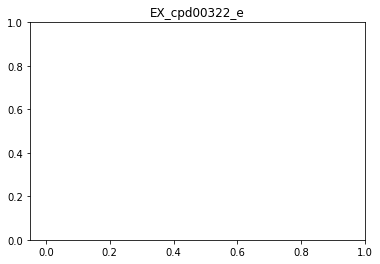

In [123]:
fig, ax = plt.subplots()
x = 43

ax.set_xlabel = 'Flux through Biomass O.F.'
ax.set_ylabel = 'No. of Ensemble Members'
ax.set(xlim=(-.05, 1), ylim=(0, 1))
bins=np.histogram(np.hstack((fluxes[carbon_sources_biolog[9]]['bio1'],fluxes[carbon_sources_biolog[22]]['bio1'], 
                             fluxes[carbon_sources_biolog[7]]['bio1'], fluxes[carbon_sources_biolog[32]]['bio1'],
                            fluxes[carbon_sources_biolog[3]]['bio1'], fluxes[carbon_sources_biolog[26]]['bio1'],
                            fluxes[carbon_sources_biolog[1]]['bio1'],fluxes[carbon_sources_biolog[40]]['bio1'],
                            fluxes[carbon_sources_biolog[44]]['bio1'])), bins=50)[1]
plt.title(carbon_sources_biolog[x])

plt.hist(fluxes[carbon_sources_biolog[x]]['bio1'],
         bins = bins,
         label=carbon_sources_biolog[x],
         color = "red",
         edgecolor='black', linewidth=1.2,
         alpha = 0.5)

plt.savefig('../results/figures/' + str(carbon_sources_biolog[x]))

In [ ]:

#for source in fluxes:
fig, ax = plt.subplots()
bins=np.histogram(np.hstack((fluxes[carbon_sources_biolog[9]]['bio1'],fluxes[carbon_sources_biolog[22]]['bio1'], 
                             fluxes[carbon_sources_biolog[7]]['bio1'], fluxes[carbon_sources_biolog[32]]['bio1'],
                            fluxes[carbon_sources_biolog[3]]['bio1'], fluxes[carbon_sources_biolog[26]]['bio1'],
                            fluxes[carbon_sources_biolog[1]]['bio1'],fluxes[carbon_sources_biolog[40]]['bio1'],
                            fluxes[carbon_sources_biolog[44]]['bio1'])), bins=50)[1]
plt.hist(fluxes[carbon_sources_biolog[0]]['bio1'],
         bins = bins,
         label=carbon_sources_biolog[0],
         color = "red",
         alpha = 0.5)
plt.hist(fluxes[carbon_sources_biolog[1]]['bio1'],
         bins = bins,
         label=carbon_sources_biolog[1],
         color = "blue",
         alpha = 0.5)
plt.hist(fluxes[carbon_sources_biolog[2]]['bio1'],
         bins = bins,
         label=carbon_sources_biolog[2],
         color = "green",
         alpha = 0.5)
plt.hist(fluxes[carbon_sources_biolog[3]]['bio1'],
         bins = bins,
         label=carbon_sources_biolog[3],
         color = "yellow",
         alpha = 0.5)
plt.hist(fluxes[carbon_sources_biolog[4]]['bio1'],
         bins = bins,
         label=carbon_sources_biolog[4],
         color = "pink",
         alpha = 0.5)
plt.hist(fluxes[carbon_sources_biolog[5]]['bio1'],
         bins = bins,
         label=carbon_sources_biolog[5],
         color = "purple",
         alpha = 0.5)
plt.hist(fluxes[carbon_sources_biolog[6]]['bio1'],
         bins = bins,
         label=carbon_sources_biolog[6],
         color = "orange",
         alpha = 0.5)
plt.hist(fluxes[carbon_sources_biolog[7]]['bio1'],
         bins = bins,
         label=carbon_sources_biolog[7],
         color = "gray",
         alpha = 0.5)
plt.hist(fluxes[carbon_sources_biolog[8]]['bio1'],
         bins = bins,
         label=carbon_sources_biolog[8],
         color = "navy",
         alpha = 0.5)
#plt.axvline(x=fluxes[carbon_sources_biolog[0]]['bio1'].mean(), c = 'red')
#plt.axvline(x=fluxes[carbon_sources_biolog[1]]['bio1'].mean(), c = 'blue')
#plt.axvline(x=fluxes[carbon_sources_biolog[2]]['bio1'].mean(), c = 'green')
#plt.axvline(x=fluxes[carbon_sources_biolog[3]]['bio1'].mean(), c = 'yellow')
#plt.axvline(x=fluxes[carbon_sources_biolog[4]]['bio1'].mean(), c = 'pink')
#plt.axvline(x=fluxes[carbon_sources_biolog[5]]['bio1'].mean(), c = 'purple')
#plt.axvline(x=fluxes[carbon_sources_biolog[6]]['bio1'].mean(), c = 'orange')
#plt.axvline(x=fluxes[carbon_sources_biolog[7]]['bio1'].mean(), c = 'gray')
#plt.axvline(x=fluxes[carbon_sources_biolog[8]]['bio1'].mean(), c = 'navy')
ax.set_ylabel('# ensemble members')
ax.set_xlabel('Flux through biomass reaction')
#ax.legend()
plt.show()



In [14]:
biolog_compositions = {}
biolog_salts_list = []
for i in biolog_salts.itertuples():
    biolog_salts_list.append(i.ID)
biolog_medias_list = []    
for i in biolog_medias.itertuples(): 
    biolog_medias_list.append(i.ID)

#add the metabolite of choice 
for i in biolog_medias_list:
    m = [i]
    media_and_salts = biolog_salts_list + m
    #print (media_and_salts)
    print (media_and_salts)

    #now I have a list including all of the salts and one carbon source, add to a dictionary of the one carbon ID and the list of salts and carbon
    
    if i in media_and_salts:
        biolog_compositions[i] = media_and_salts
    else:
        pass
    
#to ensure that the list of media sources does not add on to the end of the list, use list concatation to extend the list instead of appending the original list 


['cpd00001_e', 'cpd00007_e', 'cpd00009_e', 'cpd00011_e', 'cpd00013_e', 'cpd00030_e', 'cpd00034_e', 'cpd00048_e', 'cpd00058_e', 'cpd00063_e', 'cpd00067_e', 'cpd00099_e', 'cpd00149_e', 'cpd00205_e', 'cpd00254_e', 'cpd00971_e', 'cpd10515_e', 'cpd10516_e', 'cpd00121_e']
['cpd00001_e', 'cpd00007_e', 'cpd00009_e', 'cpd00011_e', 'cpd00013_e', 'cpd00030_e', 'cpd00034_e', 'cpd00048_e', 'cpd00058_e', 'cpd00063_e', 'cpd00067_e', 'cpd00099_e', 'cpd00149_e', 'cpd00205_e', 'cpd00254_e', 'cpd00971_e', 'cpd10515_e', 'cpd10516_e', 'cpd00281_e']
['cpd00001_e', 'cpd00007_e', 'cpd00009_e', 'cpd00011_e', 'cpd00013_e', 'cpd00030_e', 'cpd00034_e', 'cpd00048_e', 'cpd00058_e', 'cpd00063_e', 'cpd00067_e', 'cpd00099_e', 'cpd00149_e', 'cpd00205_e', 'cpd00254_e', 'cpd00971_e', 'cpd10515_e', 'cpd10516_e', 'cpd00108_e']
['cpd00001_e', 'cpd00007_e', 'cpd00009_e', 'cpd00011_e', 'cpd00013_e', 'cpd00030_e', 'cpd00034_e', 'cpd00048_e', 'cpd00058_e', 'cpd00063_e', 'cpd00067_e', 'cpd00099_e', 'cpd00149_e', 'cpd00205_e', 'c

#check to see if the metabolites are in the model
for met in model.metabolites:
    if met.id in biolog_medias_list:
        #print (met.id + " is in the model")
    else:
        #print (met.id + " is not in biolog and salts media")


In [21]:
model.metabolites.cpd00308_e

Metabolite identifier,cpd00308_e
Name,Malonate
Memory address,0x0122e99da0
Formula,C3H2O4
Compartment,e
In 2 reaction(s),"rxn12432_c, EXcpd00308_e"


In [79]:
#I now have a dictionary that has: a key identifying the carbon source and a value that contains the carbon source and all the biolog salts
#now I want to iterate over the dictionary values(which are lists) and use them as the model medium
#as per https://cobrapy.readthedocs.io/en/latest/media.html
media_names = []
for name in biolog_medias_list:
    name = str(name) + "_medium"
    media_names.append(name)

with ensemble:
    for key, value in biolog_compositions.items():
        medium = {}
        if key in model.metabolites:
            for met in value:
                medium["EX_" + met] = 1000
            #print (medium)
            model.medium = medium
            print(key + " produces " + str(model.optimize()) + " units of growth.")
        elif met in value:
            for met in value:
                medium["EX" + met] = 1000
            #print (medium)
            model.medium = medium
            print(key + " produces " + str(model.optimize()) + " units of growth.")
        else:
            print (key, " is not in the model" )
            pass
    #model.medium

AttributeError: __enter__

In [43]:
print (media_names)

['cpd00121_e', 'cpd00281_e', 'cpd00108_e', 'cpd00053_e', 'cpd00129_e', 'cpd02143_e', 'cpd00314_e', 'cpd00138_e', 'cpd00027_e', 'cpd00224_e', 'cpd00076_e', 'cpd01293_e', 'cpd00023_e', 'cpd00154_e', 'cpd00035_e', 'cpd00249_e', 'cpd00222_e', 'cpd00652_e', 'cpd00386_e', 'cpd00117_e', 'cpd00246_e', 'cpd00132_e', 'cpd00054_e', 'cpd00082_e', 'cpd00571_e', 'cpd00105_e', 'cpd00477_e', 'cpd00164_e', 'cpd00137_e', 'cpd01307_e', 'cpd00248_e', 'cpd00130_e', 'cpd00106_e', 'cpd11585_e', 'cpd00041_e', 'cpd00119_e', 'cpd00280_e', 'cpd00020_e', 'cpd00036_e', 'cpd00100_e', 'cpd02351_e', 'cpd00051_e', 'cpd19018_e', 'cpd24420_e', 'cpd00107_e', 'cpd00432_e', 'cpd11748_e', 'cpd24418_e', 'cpd11601_e', 'cps11602_e', 'cpd23859_e', 'cpd00024_e', 'cpd13391_e', 'cpd00588_e', 'cpd00182_e', 'cpd00029_e', 'cpd28989_e', 'cpd00308_e', 'cpd24417_e', 'cpd00339_e', 'cpd00797_e', 'cpd13392_e', 'cpd00080_e', 'cpd01107_e', 'cpd00066_e', 'cpd00211_e', 'cpd00136_e', 'cpd24429_e', 'cpd00820_e', 'cpd01200_e', 'cpd00162_e', 'cpd0

In [76]:
ensemble.base_model.genes.PSPTO_0727

Gene identifier,PSPTO_0727
Name,eutB
Memory address,0x011fd50cc0
Functional,True
In 1 reaction(s),rxn00539_c


In [77]:
ensemble.base_model.reactions.rxn00539_c

Reaction identifier,rxn00539_c
Name,ethanolamine ammonia-lyase (acetaldehyde-forming)
Memory address,0x011ffd1390
Stoichiometry,cpd00162_c --> cpd00013_c + cpd00071_c Aminoethanol --> NH3 + Acetaldehyde
GPR,PSPTO_0727 and PSPTO_0726
Lower bound,0.0
Upper bound,1000.0


In [82]:
ensemble.base_model.reactions.bio1.metabolites

{<Metabolite cpd00035_c at 0x11ff3cf60>: -0.02436630630824427,
 <Metabolite cpd00051_c at 0x11ff845f8>: -0.01458184157331539,
 <Metabolite cpd00132_c at 0x11ff9b4a8>: -0.0073313655159114675,
 <Metabolite cpd00041_c at 0x11ff36278>: -0.012534579934403413,
 <Metabolite cpd00084_c at 0x11ffde128>: -0.002246704710044519,
 <Metabolite cpd00023_c at 0x11fe4db38>: -0.012980735853983582,
 <Metabolite cpd00053_c at 0x11fe518d0>: -0.010459891713466151,
 <Metabolite cpd00033_c at 0x11ff387b8>: -0.017606854541936414,
 <Metabolite cpd00119_c at 0x11fee9e80>: -0.00526666208750872,
 <Metabolite cpd00322_c at 0x12018cb38>: -0.011431576333786924,
 <Metabolite cpd00107_c at 0x12004a668>: -0.0261454952260716,
 <Metabolite cpd00039_c at 0x120636630>: -0.008614980110601618,
 <Metabolite cpd00060_c at 0x11fe7dc18>: -0.005487591421057207,
 <Metabolite cpd00066_c at 0x11ffbcb00>: -0.008335279529856325,
 <Metabolite cpd00129_c at 0x11ff12080>: -0.010979353704818711,
 <Metabolite cpd00054_c at 0x11fead080>: -0.

In [90]:
media_dict = ensemble.base_model.medium.copy()
media_dict['EX_cpd00122_e'] = 0
ensemble.base_model.medium = media_dict

In [91]:
print (media_dict)

{'EX_cpd00034_e': 1000, 'EX_cpd00048_e': 1000, 'EX_cpd00205_e': 1000, 'EX_cpd00971_e': 1000, 'EX_cpd00067_e': 1000, 'EX_cpd00009_e': 1000, 'EX_cpd00001_e': 1000, 'EX_cpd00013_e': 1000, 'EX_cpd00122_e': 0, 'EX_cpd00058_e': 1000, 'EX_cpd10516_e': 1000, 'EX_cpd00149_e': 1000, 'EX_cpd00007_e': 1000, 'EX_cpd00011_e': 1000, 'EX_cpd00030_e': 1000, 'EX_cpd00063_e': 1000, 'EX_cpd00099_e': 1000, 'EX_cpd00254_e': 1000, 'EX_cpd10515_e': 1000, 'EX_cpd00028_e': 0.1, 'EX_cpd00268_e': 1000}


In [92]:
from medusa.flux_analysis import flux_balance
fluxes = flux_balance.optimize_ensemble(ensemble, return_flux = 'bio1')

In [95]:
ensemble.base_model.medium = {}

In [96]:
single_model = ensemble.extract_member(ensemble.members[0])

In [102]:

for met in single_model.metabolites:
    dm_rxn = cobra.Reaction('DM_'+met.id)
    dm_rxn.add_metabolites({met:-1})
    with single_model:
        single_model.add_reactions([dm_rxn])
        single_model.objective = dm_rxn
        print(met.id,single_model.optimize())

cpd00067_c <Solution 0.000 at 0x11cfa3400>
cpd00001_c <Solution 0.000 at 0x11cfa3390>
cpd00009_c <Solution 0.000 at 0x11cfa34e0>
cpd00012_c <Solution 0.000 at 0x11cfa3748>
cpd00013_c <Solution 0.000 at 0x11cfa3898>
cpd00742_c <Solution 0.000 at 0x11cfa3860>
cpd00011_c <Solution 0.000 at 0x11cfa3978>
cpd03049_c <Solution 0.000 at 0x11cfa3390>
cpd00056_c <Solution 0.000 at 0x11cfa3c18>
cpd00020_c <Solution 0.000 at 0x11cfa3da0>
cpd00076_c <Solution 0.000 at 0x11cfa3e48>
cpd02298_c <Solution 0.000 at 0x11cfa3f60>
cpd00027_c <Solution 0.000 at 0x11cf94048>
cpd00158_c <Solution 0.000 at 0x11cf94080>
cpd00190_c <Solution 0.000 at 0x11cf94198>
cpd01420_c <Solution 0.000 at 0x11cf94208>
cpd00007_c <Solution 0.000 at 0x11cf942b0>
cpd00304_c <Solution 0.000 at 0x11cf94390>
cpd00338_c <Solution 0.000 at 0x11cf943c8>
cpd00689_c <Solution 0.000 at 0x11cf944e0>
cpd02656_c <Solution 0.000 at 0x11cf94588>
cpd00220_c <Solution 0.000 at 0x11cf946a0>
cpd02882_c <Solution 0.000 at 0x11cf94978>
cpd00017_c 

In [105]:
single_model.metabolites.cpd11493_c.reactions

frozenset({<Reaction EX_cpd11493_c at 0x11d020da0>,
           <Reaction bio1 at 0x11d03c080>,
           <Reaction cor0004_c at 0x11c796ef0>,
           <Reaction cor0006_c at 0x11c796f60>,
           <Reaction cor0008_c at 0x11c796fd0>,
           <Reaction rxn05346_c at 0x11d14f160>,
           <Reaction rxn05348_c at 0x11d14f198>,
           <Reaction rxn05349_c at 0x11d14f1d0>,
           <Reaction rxn05350_c at 0x11d14f208>,
           <Reaction rxn05358_c at 0x11d14f240>,
           <Reaction rxn05359_c at 0x11c7de2e8>,
           <Reaction rxn05363_c at 0x11c7dea20>,
           <Reaction rxn05367_c at 0x11d14f2e8>,
           <Reaction rxn05371_c at 0x11cf94da0>,
           <Reaction rxn05375_c at 0x11ca37ba8>,
           <Reaction rxn05379_c at 0x11ca37cf8>,
           <Reaction rxn05383_c at 0x11d14f400>,
           <Reaction rxn05384_c at 0x11c81e5c0>,
           <Reaction rxn05388_c at 0x11cfa1c18>,
           <Reaction rxn05392_c at 0x11d14f4a8>,
           <Reaction rxn05

In [122]:
single_model.reactions.cor0001_c

Reaction identifier,cor0001_c
Name,Isoleucine Epimerase
Memory address,0x011c796e48
Stoichiometry,cpd00322_c <=> cor00001_c L-Isoleucine <=> L-alloisoleucine
GPR,PSPTO_0259 or PSPTO_0301
Lower bound,-1000.0
Upper bound,1000.0


In [121]:
single_model.metabolites.cor00001_c

Metabolite identifier,cor00001_c
Name,L-alloisoleucine
Memory address,0x011cadc0f0
Formula,C6H13NO2
Compartment,c
In 2 reaction(s),"cor0002_c, cor0001_c"


In [118]:
single_model.metabolites.cpd00070_c

Metabolite identifier,cpd00070_c
Name,Malonyl-CoA
Memory address,0x011c412d68
Formula,C24H33N7O19P3S
Compartment,c
In 6 reaction(s),"rxn05465_c, rxn10036_c, rxn25741_c, cor0010_c, rxn06673_c, cor0004_c"


In [119]:
single_model.metabolites.cpd00078_c

Metabolite identifier,cpd00078_c
Name,Succinyl-CoA
Memory address,0x011d2bd940
Formula,C25H35N7O19P3S
Compartment,c
In 6 reaction(s),"rxn00290_c, rxn25164_c, rxn08094_c, rxn01304_c, cor0003_c, cor0004_c"


In [120]:
single_model.metabolites.cpd11493_c

Metabolite identifier,cpd11493_c
Name,ACP
Memory address,0x011c3f5e10
Formula,C11H22N2O7PRS
Compartment,c
In 44 reaction(s),"bio1, rxn05451_c, rxn05452_c, rxn05346_c, rxn05453_c, rxn05348_c, rxn05454_c, rxn05349_c, rxn05455_c, rxn08551_c, rxn05350_c, rxn05396_c, rxn05456_c, rxn05363_c, rxn05358_c, rxn05457_c, rxn05458_c,..."


In [112]:
for rxn in ensemble.base_model.reactions:
    if "cpd00011_c" in str(rxn.metabolites):
        print (rxn.id, rxn.bounds)

rxn00002_c (0.0, 1000.0)
rxn00011_c (0.0, 1000.0)
rxn00101_c (0.0, 1000.0)
rxn00113_c (-1000.0, 1000.0)
rxn00127_c (0.0, 1000.0)
rxn00159_c (0.0, 1000.0)
rxn00161_c (0.0, 1000.0)
rxn00247_c (0.0, 1000.0)
rxn00405_c (0.0, 1000.0)
rxn00470_c (0.0, 1000.0)
rxn00501_c (-1000.0, 1000.0)
rxn00671_c (-1000.0, 1000.0)
rxn00710_c (0.0, 1000.0)
rxn00866_c (-1000.0, 1000.0)
rxn00908_c (-1000.0, 1000.0)
rxn01000_c (0.0, 1000.0)
rxn01268_c (0.0, 1000.0)
rxn01269_c (0.0, 1000.0)
rxn01802_c (-1000.0, 1000.0)
rxn02277_c (0.0, 1000.0)
rxn02288_c (-1000.0, 1000.0)
rxn02297_c (0.0, 1000.0)
rxn02303_c (-1000.0, 1000.0)
rxn02341_c (0.0, 1000.0)
rxn02507_c (0.0, 1000.0)
rxn03384_c (-1000.0, 1000.0)
rxn03909_c (0.0, 1000.0)
rxn04704_c (-1000.0, 1000.0)
rxn05064_c (-1000.0, 1000.0)
rxn05346_c (0.0, 1000.0)
rxn05348_c (0.0, 1000.0)
rxn05350_c (0.0, 1000.0)
rxn05367_c (0.0, 1000.0)
rxn05392_c (0.0, 1000.0)
rxn05400_c (0.0, 1000.0)
rxn05413_c (0.0, 1000.0)
rxn05417_c (0.0, 1000.0)
rxn08094_c (-1000.0, 1000.0)
rx

In [47]:
for rxn in ensemble.base_model.reactions:
    if "RXN-88" in rxn.name:
        print (rxn.id, rxn.name)

rxn25164_c RXN-8807.c
rxn37797_c RXN-8850.d


In [75]:
ensemble.base_model.genes.PSPTO_0983

Gene identifier,PSPTO_0983
Name,G_PSPTO_0983
Memory address,0x07fdd58697908
Functional,True
In 1 reaction(s),rxn02186_c


In [85]:
ensemble.base_model.reactions.rxn00903_c

Reaction identifier,rxn00903_c
Name,L-Valine:2-oxoglutarate aminotransferase
Memory address,0x07fdd8b28c0f0
Stoichiometry,cpd00024_c + cpd00156_c <=> cpd00023_c + cpd00123_c 2-Oxoglutarate + L-Valine <=> L-Glutamate + 3-Methyl-2-oxobutanoate
GPR,PSPTO_1332
Lower bound,-1000.0
Upper bound,1000.0


In [88]:
ensemble.base_model.metabolites.cpd00508_c

Metabolite identifier,cpd00508_c
Name,3MOP
Memory address,0x07fdd8b29e470
Formula,C6H9O3
Compartment,c
In 6 reaction(s),"rxn11347_c, rxn02269_c, rxn03437_c, rxn33937_c, rxn02950_c, rxn01575_c"


In [77]:
ensemble.base_model.metabolites.cpd00668_c

Metabolite identifier,cpd00668_c
Name,ALCTT
Memory address,0x07fdd8b29ef28
Formula,C5H7O4
Compartment,c
In 2 reaction(s),"rxn02186_c, rxn02185_c"
